In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [16]:
# Path to your file (update path if needed)
#sep 2008
#xls_path = "../Data/Sep2008.xlsx"

#March 2020
xls_path = "../Data/March2020_10000Fish.xlsx"
# Load the Excel file using the default engine (xlrd for .xls)
df = pd.read_excel(xls_path)

# Preview the data
print(df.head())
print(df.columns)
# Select explicitly the numeric runtime columns for analysis
time_columns = [
    'time_binomial', 
    'time_lsmc_cpu', 
    'time_lsmc_gpu', 
    'time_pso_cpu', 
    'time_pso_gpu'
]

# Ensure all selected columns exist and convert to numeric (coerce errors)
for col in time_columns:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    else:
        print(f"Warning: Column {col} not found in the data.")
# Ensure 'delta' column is numeric as well
df['delta'] = pd.to_numeric(df['delta'], errors='coerce')

# Drop rows with NaN delta, as they are essential for grouping
df = df.dropna(subset=['delta'])

    secid      date cp_flag  days  delta  impl_volatility  impl_strike  \
0  108105  2-Mar-20       C    30     90         0.361254     2718.367   
1  108105  2-Mar-20       C    30     80         0.339968     2858.943   
2  108105  2-Mar-20       C    30     75         0.327053     2912.351   
3  108105  2-Mar-20       C    30     70         0.313548     2958.734   
4  108105  2-Mar-20       C    30     60         0.286324     3035.886   

   impl_premium  dispersion  _1_MO  ...    lsmc_cpu    lsmc_gpu     pso_cpu  \
0      386.5583    0.017356   1.41  ...  389.355602  388.794859  390.615875   
1      265.5256    0.020391   1.41  ...  267.520341  267.490993  269.288544   
2      222.2547    0.020754   1.41  ...  225.867322  225.849503  225.886353   
3      186.0717    0.020678   1.41  ...  189.588198  189.571486  189.515610   
4      129.3596    0.019974   1.41  ...  132.357931  132.327427  132.348297   

      pso_gpu  time_mc_setup  time_binomial  time_lsmc_cpu  time_lsmc_gpu  \
0  

### 2. Calculate Moneyness and Basis Metrics




In [17]:
df['moneyness'] = df['impl_strike'] / df['close']

# Define models to compare
model_columns = ['binomial', 'lsmc_cpu', 'lsmc_gpu', 'pso_cpu', 'pso_gpu']

# Calculate basis error = model price - implied market premium
for col in model_columns:
    df[f'diff_{col}'] = df[col] - df['impl_premium']
    df[f'diff_binomial_{col}'] = df[col] - df['binomial']


### 3. Visualize Scatter: Model vs Implied Premium


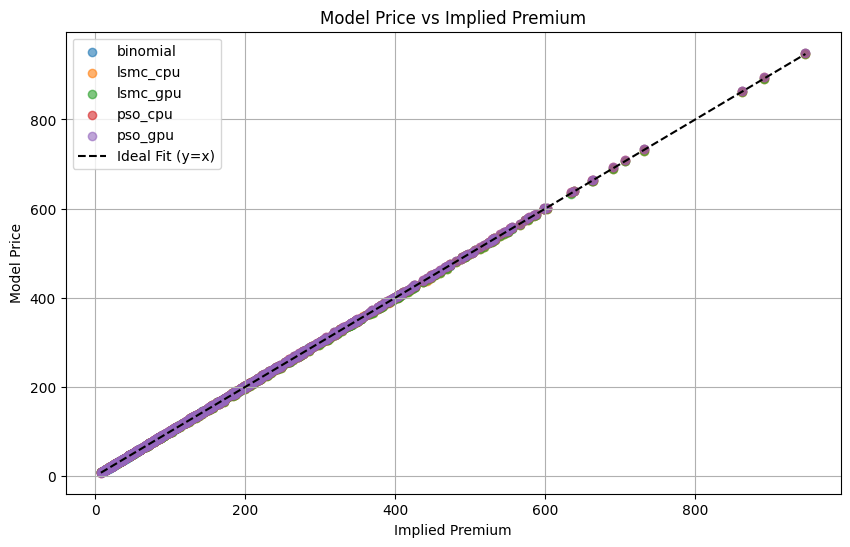

In [18]:
plt.figure(figsize=(10, 6))
for col in model_columns:
    plt.scatter(df['impl_premium'], df[col], label=col, alpha=0.6)

plt.plot([df['impl_premium'].min(), df['impl_premium'].max()],
         [df['impl_premium'].min(), df['impl_premium'].max()],
         'k--', label='Ideal Fit (y=x)')
plt.xlabel('Implied Premium')
plt.ylabel('Model Price')
plt.legend()
plt.title('Model Price vs Implied Premium')
plt.grid(True)
plt.show()

### 4. Histogram of Pricing Error (Bias)

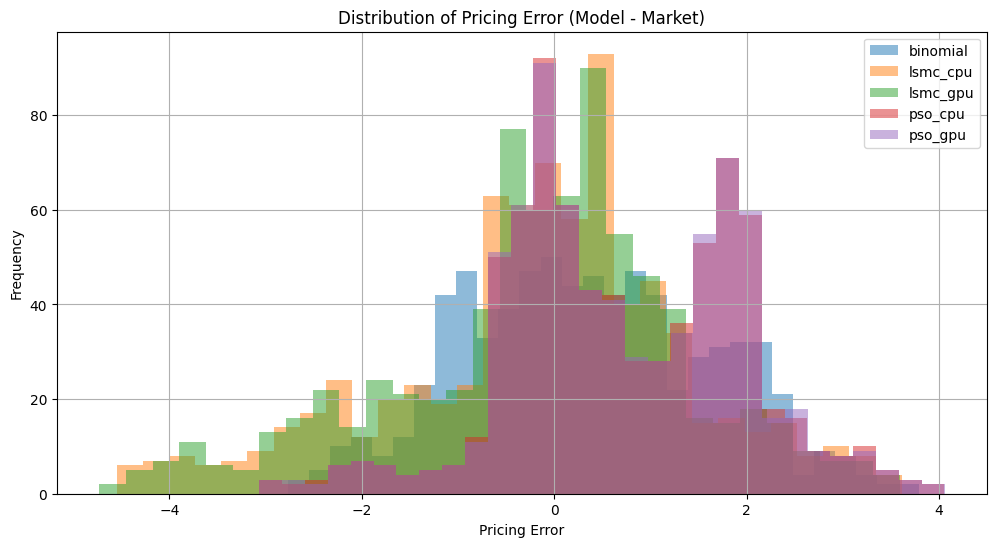

In [19]:
plt.figure(figsize=(12, 6))
for col in model_columns:
    plt.hist(df[f'diff_{col}'], bins=30, alpha=0.5, label=col)

plt.title('Distribution of Pricing Error (Model - Market)')
plt.xlabel('Pricing Error')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

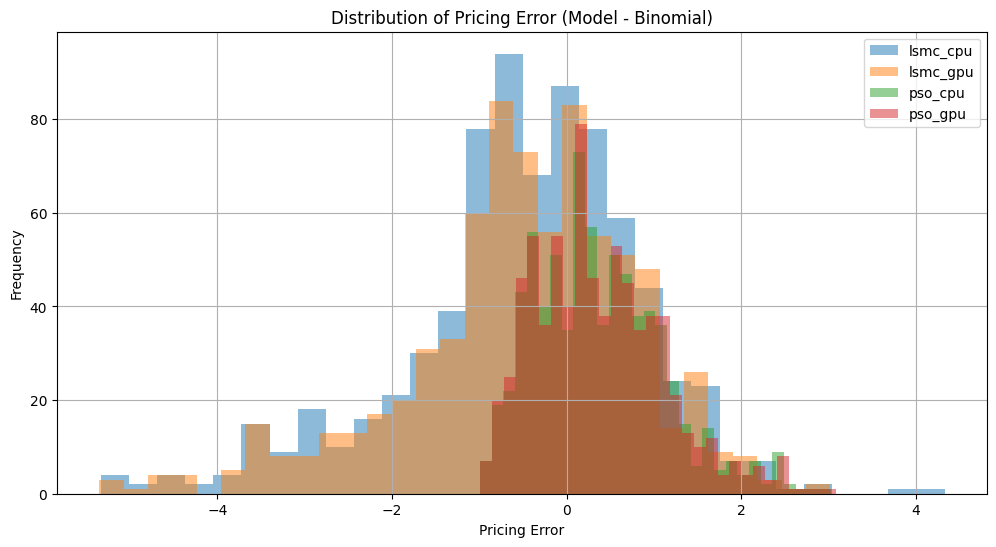

In [20]:
plt.figure(figsize=(12, 6))
for col in model_columns:
    if col == 'binomial':
        continue
    plt.hist(df[f'diff_binomial_{col}'], bins=30, alpha=0.5, label=col)

plt.title('Distribution of Pricing Error (Model - Binomial)')
plt.xlabel('Pricing Error')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

### 5. Plot Error vs Moneyness

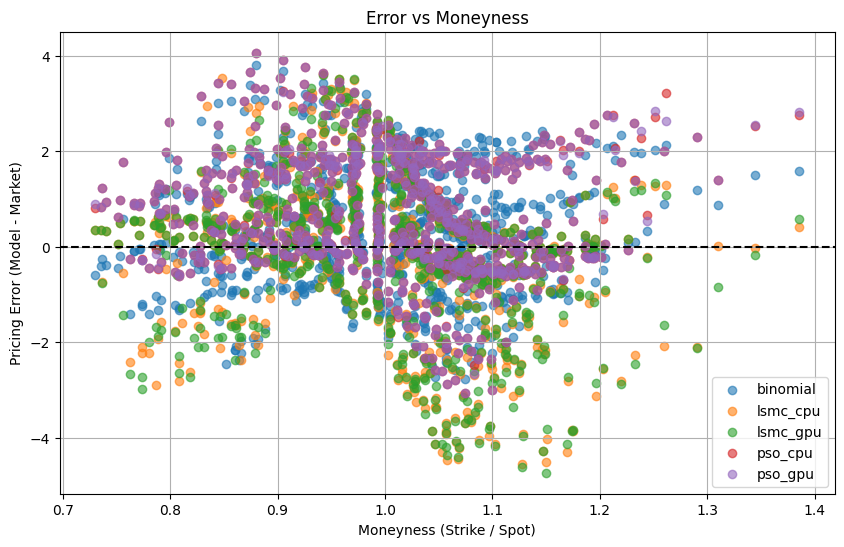

In [21]:
plt.figure(figsize=(10, 6))
for col in model_columns:
    plt.scatter(df['moneyness'], df[f'diff_{col}'], label=col, alpha=0.6)

plt.axhline(0, color='k', linestyle='--')
plt.xlabel('Moneyness (Strike / Spot)')
plt.ylabel('Pricing Error (Model - Market)')
plt.title('Error vs Moneyness')
plt.legend()
plt.grid(True)
plt.show()

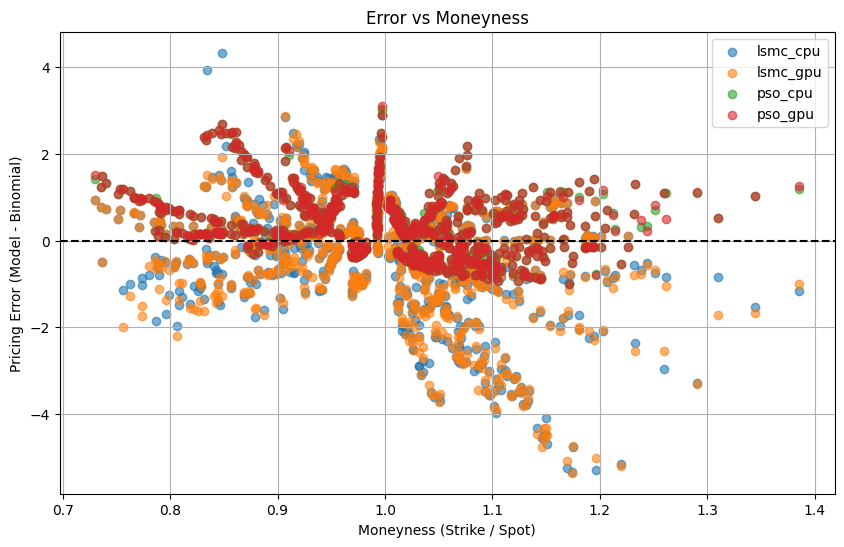

In [22]:
plt.figure(figsize=(10, 6))
for col in model_columns:
    if col=="binomial":
        continue
    plt.scatter(df['moneyness'], df[f'diff_binomial_{col}'], label=col, alpha=0.6)

plt.axhline(0, color='k', linestyle='--')
plt.xlabel('Moneyness (Strike / Spot)')
plt.ylabel('Pricing Error (Model - Binomial)')
plt.title('Error vs Moneyness')
plt.legend()
plt.grid(True)
plt.show()

### 6. Bias Summary Table


In [23]:

bias_summary = {
    'model': [],
    'mean_error': [],
    'mean_abs_error': [],
    'rmse': []
}

for col in model_columns:
    error = df[f'diff_{col}']
    bias_summary['model'].append(col)
    bias_summary['mean_error'].append(error.mean())
    bias_summary['mean_abs_error'].append(np.abs(error).mean())
    bias_summary['rmse'].append(np.sqrt((error**2).mean()))

bias_df = pd.DataFrame(bias_summary)
print(bias_df)


      model  mean_error  mean_abs_error      rmse
0  binomial    0.344475        1.075545  1.324304
1  lsmc_cpu   -0.136785        1.165395  1.556012
2  lsmc_gpu   -0.153418        1.156349  1.543203
3   pso_cpu    0.717696        1.099975  1.416698
4   pso_gpu    0.716781        1.100719  1.416503


In [24]:

binbias_summary = {
    'model': [],
    'mean_error': [],
    'mean_abs_error': [],
    'rmse': []
}

for col in model_columns:
    if col=="binomial":
        continue
    error = df[f'diff_binomial_{col}']
    binbias_summary['model'].append(col)
    binbias_summary['mean_error'].append(error.mean())
    binbias_summary['mean_abs_error'].append(np.abs(error).mean())
    binbias_summary['rmse'].append(np.sqrt((error**2).mean()))

binbias_df = pd.DataFrame(binbias_summary)
print(binbias_df)


      model  mean_error  mean_abs_error      rmse
0  lsmc_cpu   -0.481261        1.055611  1.436379
1  lsmc_gpu   -0.497893        1.051188  1.422822
2   pso_cpu    0.373220        0.633549  0.825098
3   pso_gpu    0.372306        0.633464  0.826110


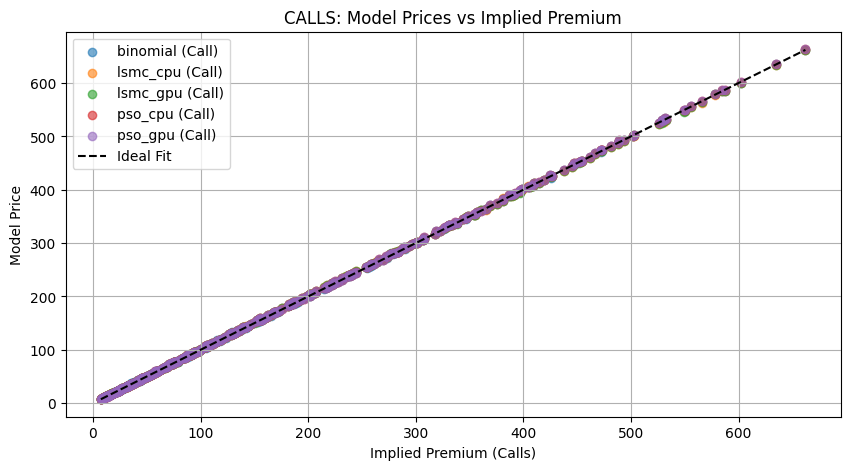

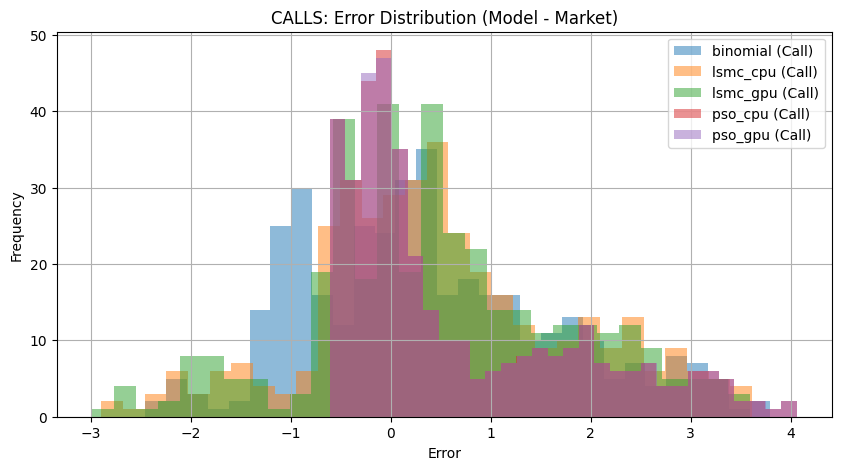

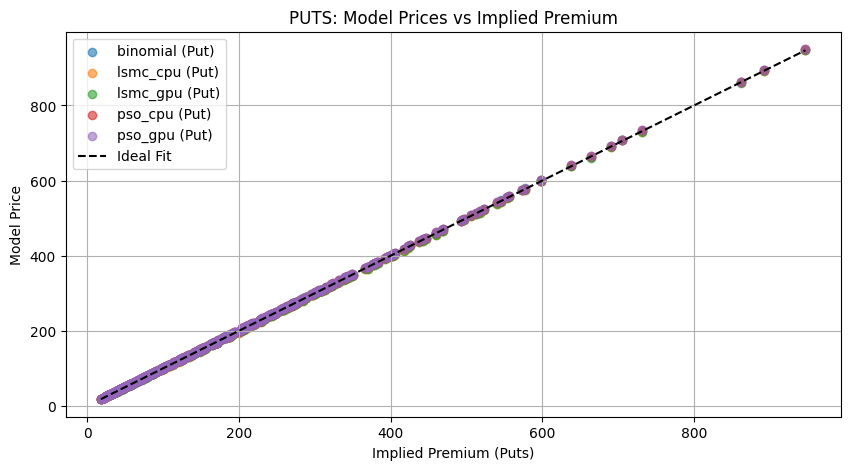

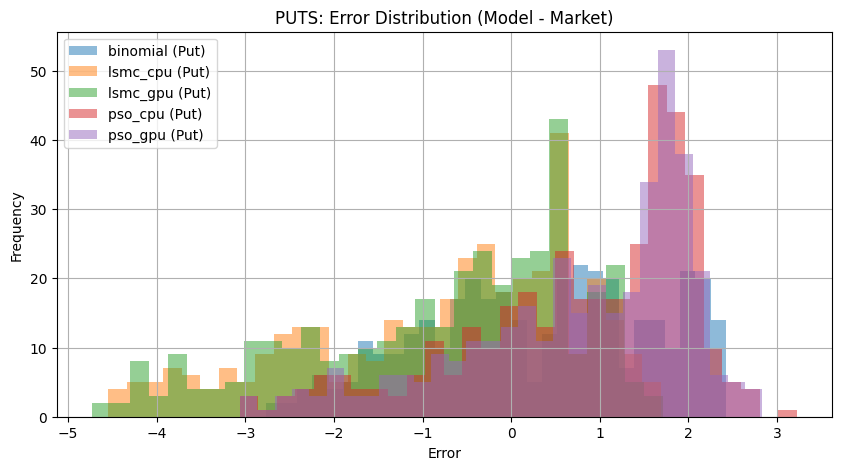

In [25]:
# Split into calls and puts
calls = df[df['cp_flag'] == 'C']
puts = df[df['cp_flag'] == 'P']
models=model_columns
# -------- CALL OPTIONS ANALYSIS --------
plt.figure(figsize=(10, 5))
for model in models:
    plt.scatter(calls['impl_premium'], calls[model], label=f'{model} (Call)', alpha=0.6)
plt.plot([calls['impl_premium'].min(), calls['impl_premium'].max()],
         [calls['impl_premium'].min(), calls['impl_premium'].max()],
         'k--', label='Ideal Fit')
plt.xlabel('Implied Premium (Calls)')
plt.ylabel('Model Price')
plt.title('CALLS: Model Prices vs Implied Premium')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
for model in models:
    plt.hist(calls[f'diff_{model}'], bins=30, alpha=0.5, label=f'{model} (Call)')
plt.title("CALLS: Error Distribution (Model - Market)")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

# -------- PUT OPTIONS ANALYSIS --------
plt.figure(figsize=(10, 5))
for model in models:
    plt.scatter(puts['impl_premium'], puts[model], label=f'{model} (Put)', alpha=0.6)
plt.plot([puts['impl_premium'].min(), puts['impl_premium'].max()],
         [puts['impl_premium'].min(), puts['impl_premium'].max()],
         'k--', label='Ideal Fit')
plt.xlabel('Implied Premium (Puts)')
plt.ylabel('Model Price')
plt.title('PUTS: Model Prices vs Implied Premium')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
for model in models:
    plt.hist(puts[f'diff_{model}'], bins=30, alpha=0.5, label=f'{model} (Put)')
plt.title("PUTS: Error Distribution (Model - Market)")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

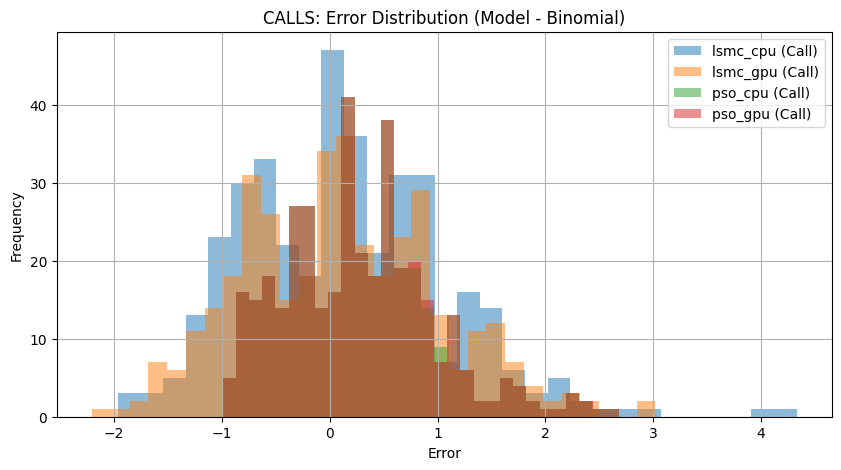

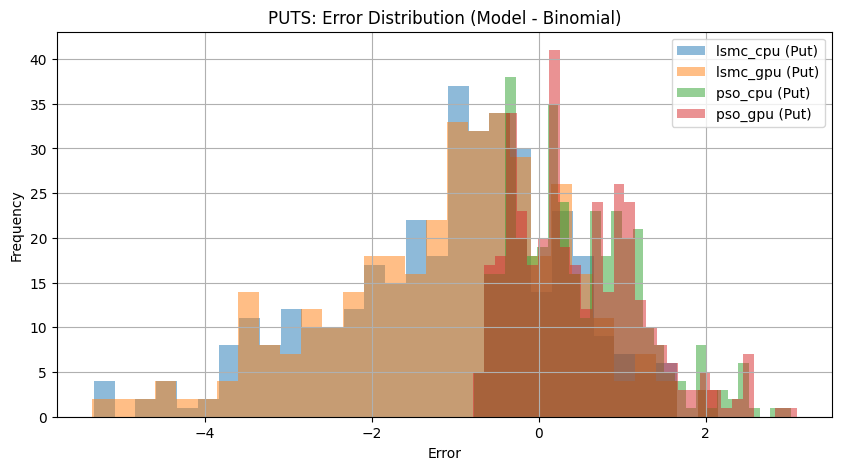

In [26]:
# Split into calls and puts
models=model_columns
# -------- CALL OPTIONS ANALYSIS --------
plt.figure(figsize=(10, 5))
for model in models:
    if model=="binomial":
        continue
    plt.hist(calls[f'diff_binomial_{model}'], bins=30, alpha=0.5, label=f'{model} (Call)')
plt.title("CALLS: Error Distribution (Model - Binomial)")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

# -------- PUT OPTIONS ANALYSIS --------


plt.figure(figsize=(10, 5))
for model in models:
    if model=="binomial":
        continue
    plt.hist(puts[f'diff_binomial_{model}'], bins=30, alpha=0.5, label=f'{model} (Put)')
plt.title("PUTS: Error Distribution (Model - Binomial)")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

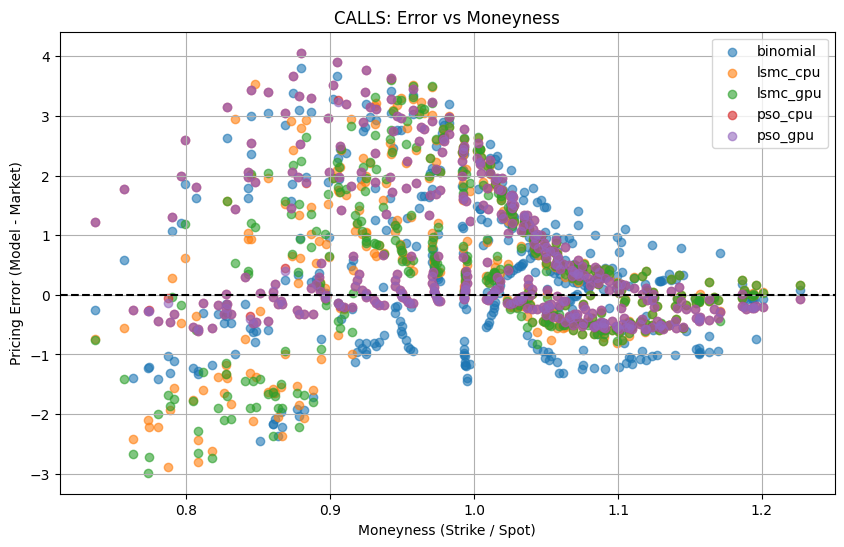


📊 CALL Option Bias Summary:
       model  mean_error  mean_abs_error      rmse
0  binomial    0.373085        1.028973  1.323928
1  lsmc_cpu    0.508136        1.046166  1.381501
2  lsmc_gpu    0.470595        1.035090  1.362009
3   pso_cpu    0.644235        0.880103  1.323861
4   pso_gpu    0.643587        0.880306  1.323648


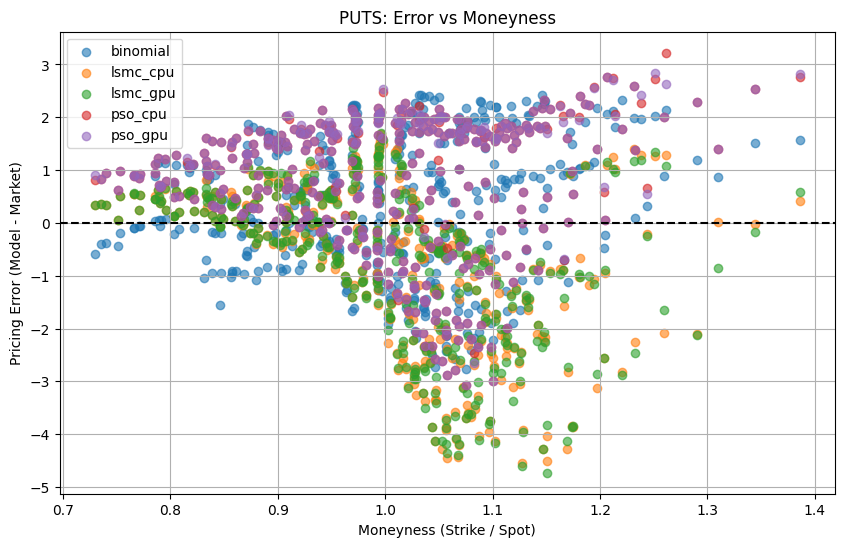


📊 PUT Option Bias Summary:
       model  mean_error  mean_abs_error      rmse
0  binomial    0.315865        1.122117  1.324680
1  lsmc_cpu   -0.781707        1.284624  1.712835
2  lsmc_gpu   -0.777431        1.277607  1.705252
3   pso_cpu    0.791157        1.319847  1.503813
4   pso_gpu    0.789976        1.321132  1.503636


In [27]:
# ------- CALLS: Error vs Moneyness -------
plt.figure(figsize=(10, 6))
for col in model_columns:
    plt.scatter(calls['moneyness'], calls[f'diff_{col}'], label=col, alpha=0.6)
plt.axhline(0, color='k', linestyle='--')
plt.xlabel('Moneyness (Strike / Spot)')
plt.ylabel('Pricing Error (Model - Market)')
plt.title('CALLS: Error vs Moneyness')
plt.legend()
plt.grid(True)
plt.show()

# ------- CALLS: Bias Summary -------
bias_summary_calls = {
    'model': [],
    'mean_error': [],
    'mean_abs_error': [],
    'rmse': []
}
for col in model_columns:
    error = calls[f'diff_{col}']
    bias_summary_calls['model'].append(col)
    bias_summary_calls['mean_error'].append(error.mean())
    bias_summary_calls['mean_abs_error'].append(np.abs(error).mean())
    bias_summary_calls['rmse'].append(np.sqrt((error**2).mean()))
bias_df_calls = pd.DataFrame(bias_summary_calls)
print("\n📊 CALL Option Bias Summary:\n", bias_df_calls)



# ------- PUTS: Error vs Moneyness -------
plt.figure(figsize=(10, 6))
for col in model_columns:
    plt.scatter(puts['moneyness'], puts[f'diff_{col}'], label=col, alpha=0.6)
plt.axhline(0, color='k', linestyle='--')
plt.xlabel('Moneyness (Strike / Spot)')
plt.ylabel('Pricing Error (Model - Market)')
plt.title('PUTS: Error vs Moneyness')
plt.legend()
plt.grid(True)
plt.show()

# ------- PUTS: Bias Summary -------
bias_summary_puts = {
    'model': [],
    'mean_error': [],
    'mean_abs_error': [],
    'rmse': []
}
for col in model_columns:
    error = puts[f'diff_{col}']
    bias_summary_puts['model'].append(col)
    bias_summary_puts['mean_error'].append(error.mean())
    bias_summary_puts['mean_abs_error'].append(np.abs(error).mean())
    bias_summary_puts['rmse'].append(np.sqrt((error**2).mean()))
bias_df_puts = pd.DataFrame(bias_summary_puts)
print("\n📊 PUT Option Bias Summary:\n", bias_df_puts)

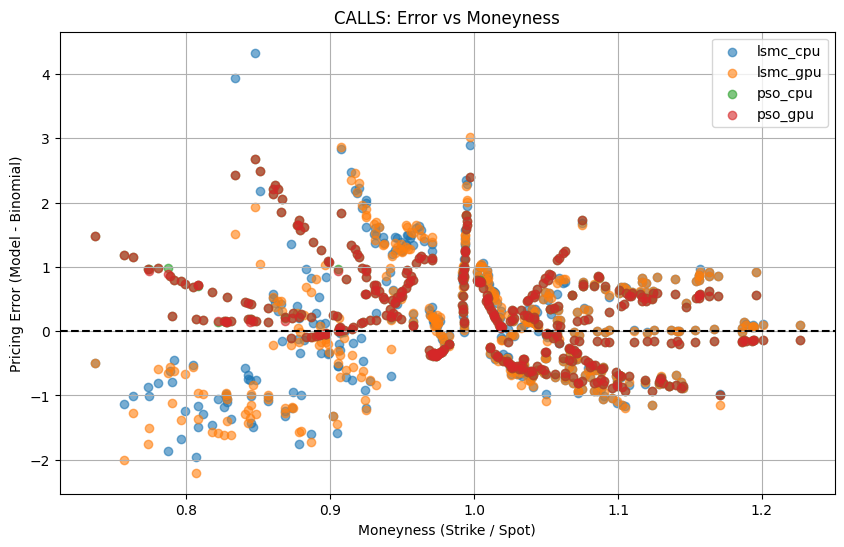


📊 CALL Option Bias Summary:
       model  mean_error  mean_abs_error      rmse
0  lsmc_cpu    0.135051        0.736681  0.945571
1  lsmc_gpu    0.097510        0.735312  0.917806
2   pso_cpu    0.271150        0.583664  0.747024
3   pso_gpu    0.270502        0.583023  0.746489


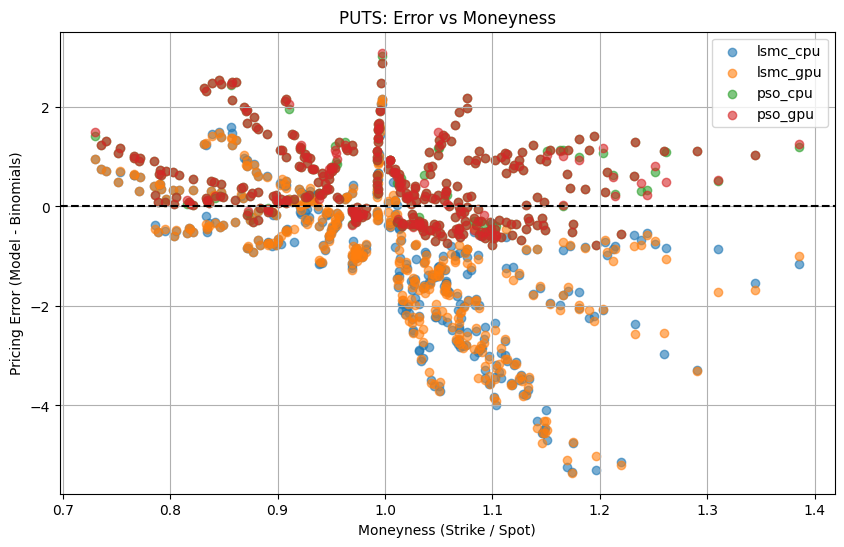


📊 PUT Option Bias Summary:
       model  mean_error  mean_abs_error      rmse
0  lsmc_cpu   -1.097572        1.374541  1.797850
1  lsmc_gpu   -1.093297        1.367064  1.790665
2   pso_cpu    0.475291        0.683433  0.896398
3   pso_gpu    0.474110        0.683905  0.898704


In [28]:
# ------- CALLS: Error vs Moneyness -------
plt.figure(figsize=(10, 6))
for col in model_columns:
    if col=="binomial":
        continue
    plt.scatter(calls['moneyness'], calls[f'diff_binomial_{col}'], label=col, alpha=0.6)
plt.axhline(0, color='k', linestyle='--')
plt.xlabel('Moneyness (Strike / Spot)')
plt.ylabel('Pricing Error (Model - Binomial)')
plt.title('CALLS: Error vs Moneyness')
plt.legend()
plt.grid(True)
plt.show()

# ------- CALLS: Bias Summary -------
bias_summary_calls = {
    'model': [],
    'mean_error': [],
    'mean_abs_error': [],
    'rmse': []
}
for col in model_columns:
    if col=="binomial":
        continue
    error = calls[f'diff_binomial_{col}']
    bias_summary_calls['model'].append(col)
    bias_summary_calls['mean_error'].append(error.mean())
    bias_summary_calls['mean_abs_error'].append(np.abs(error).mean())
    bias_summary_calls['rmse'].append(np.sqrt((error**2).mean()))
bias_df_calls = pd.DataFrame(bias_summary_calls)
print("\n📊 CALL Option Bias Summary:\n", bias_df_calls)



# ------- PUTS: Error vs Moneyness -------
plt.figure(figsize=(10, 6))
for col in model_columns:
     if col=="binomial":
        continue
     plt.scatter(puts['moneyness'], puts[f'diff_binomial_{col}'], label=col, alpha=0.6)
plt.axhline(0, color='k', linestyle='--')
plt.xlabel('Moneyness (Strike / Spot)')
plt.ylabel('Pricing Error (Model - Binomials)')
plt.title('PUTS: Error vs Moneyness')
plt.legend()
plt.grid(True)
plt.show()

# ------- PUTS: Bias Summary -------
bias_summary_puts = {
    'model': [],
    'mean_error': [],
    'mean_abs_error': [],
    'rmse': []
}
for col in model_columns:
    if col=="binomial":
        continue
    error = puts[f'diff_binomial_{col}']
    bias_summary_puts['model'].append(col)
    bias_summary_puts['mean_error'].append(error.mean())
    bias_summary_puts['mean_abs_error'].append(np.abs(error).mean())
    bias_summary_puts['rmse'].append(np.sqrt((error**2).mean()))
bias_df_puts = pd.DataFrame(bias_summary_puts)
print("\n📊 PUT Option Bias Summary:\n", bias_df_puts)

### 7 time spending analysis 

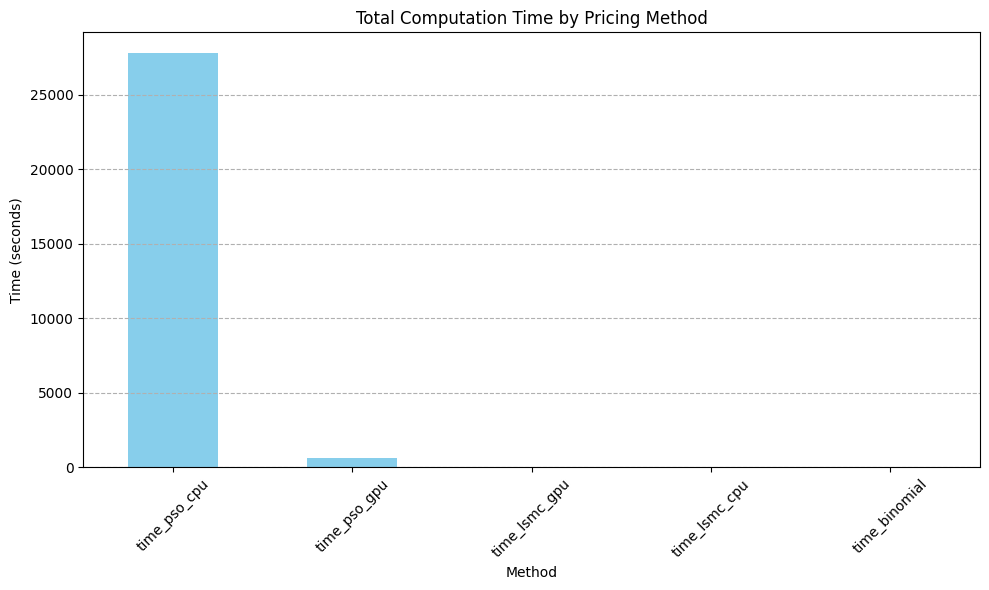

In [29]:
# Convert specified columns to numeric, handle potential errors
df[time_columns] = df[time_columns].apply(pd.to_numeric, errors='coerce')

# Drop rows where 'moneyness' or any critical time column is NaN
df = df.dropna(subset=['moneyness'] + time_columns)

# Group by moneyness category (optionally round for clarity)
df['moneyness_bucket'] = df['moneyness'].round(2)  # adjust rounding precision as needed

# Group and sum times by moneyness_bucket
grouped_df = df.groupby('moneyness_bucket')[time_columns].sum()

# Compute overall totals for each method
total_times = grouped_df.sum().sort_values(ascending=False)





# Plot 1: Total computation time for each method
plt.figure(figsize=(10, 6))
total_times.plot(kind='bar', color='skyblue')
plt.title('Total Computation Time by Pricing Method')
plt.ylabel('Time (seconds)')
plt.xlabel('Method')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()



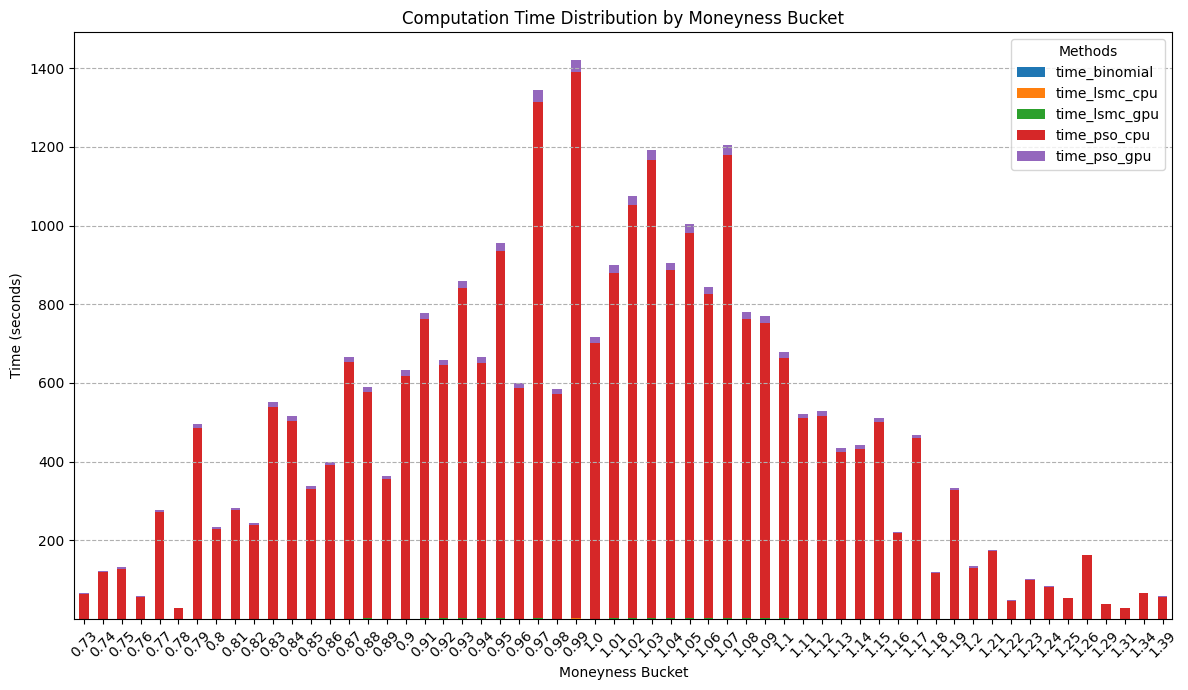

In [30]:
# Plot 2: Time distribution per method across different moneyness buckets
grouped_df.plot(kind='bar', stacked=True, figsize=(12, 7))
plt.title('Computation Time Distribution by Moneyness Bucket')
plt.ylabel('Time (seconds)')
plt.xlabel('Moneyness Bucket')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')
plt.legend(title='Methods')
plt.tight_layout()
plt.show()



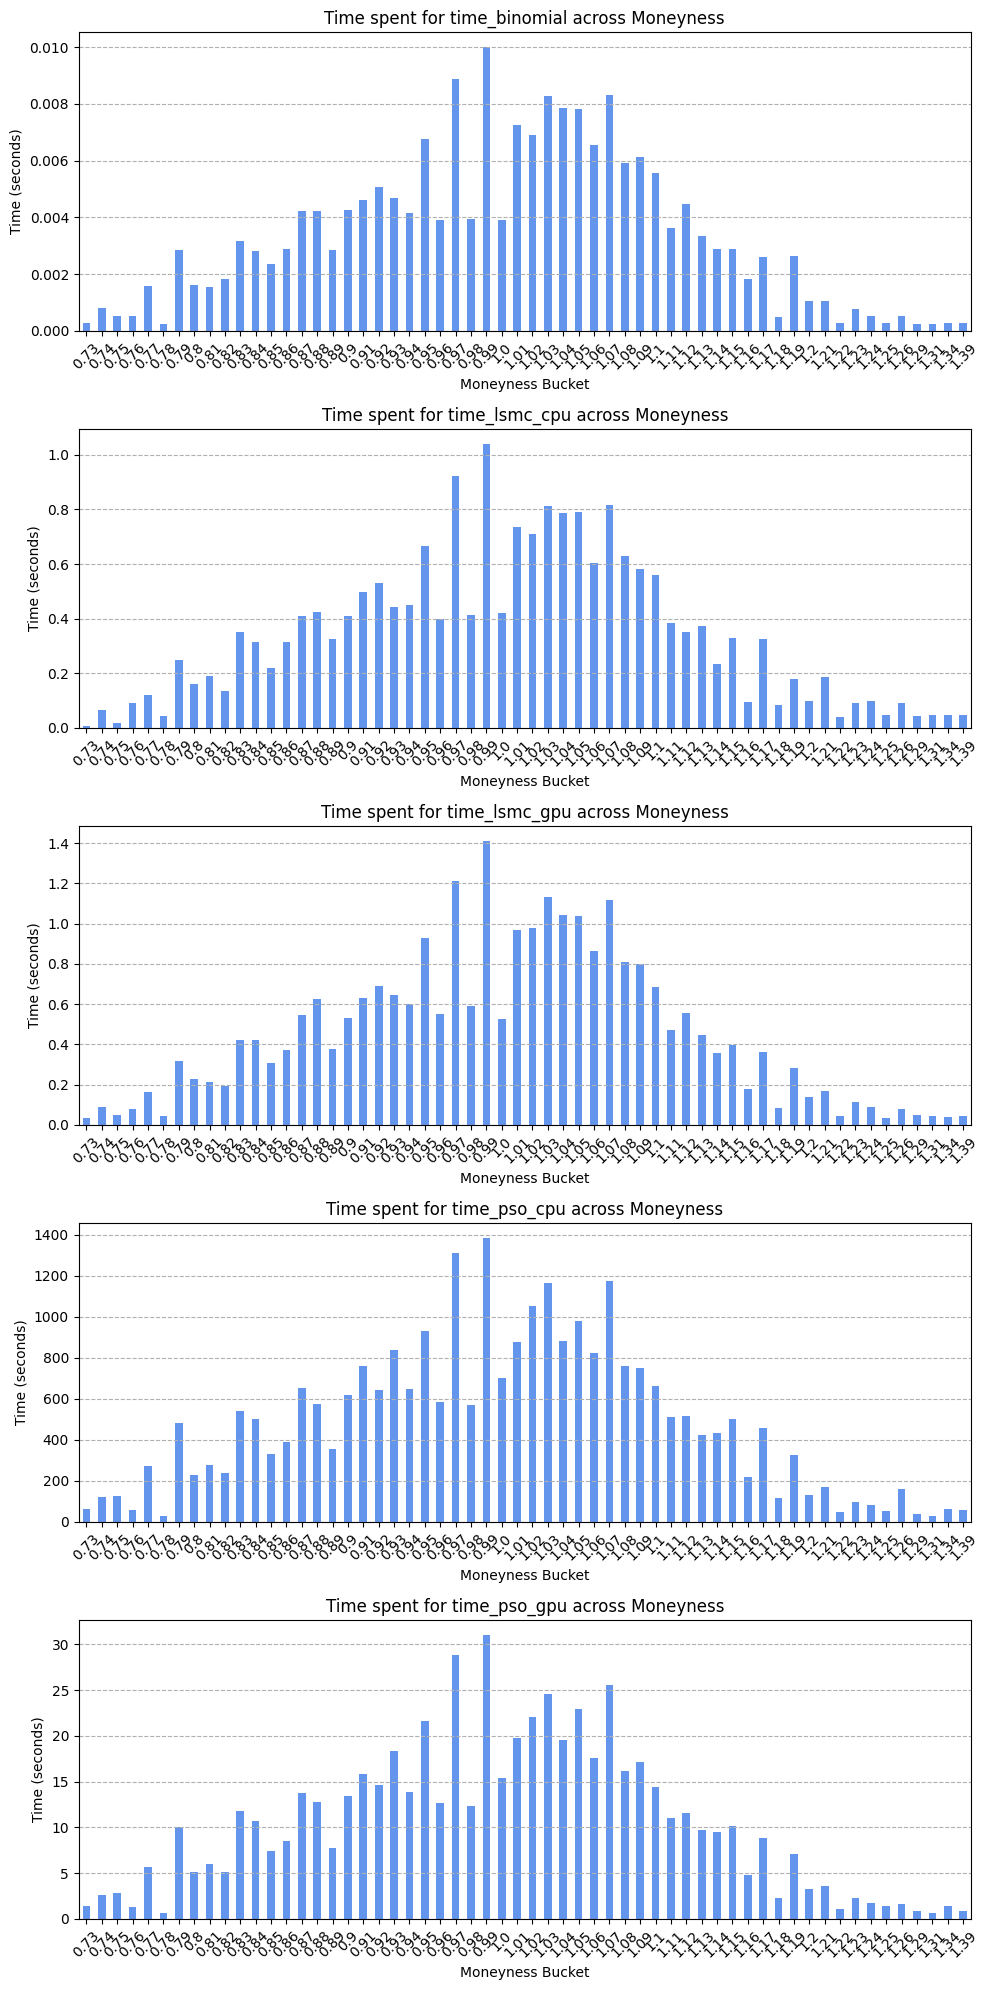

In [31]:
fig, axes = plt.subplots(len(time_columns), 1, figsize=(10, 20), sharex=False)

for i, col in enumerate(time_columns):
    grouped_df[col].plot(kind='bar', ax=axes[i], color='cornflowerblue')
    axes[i].set_title(f'Time spent for {col} across Moneyness')
    axes[i].set_ylabel('Time (seconds)')
    axes[i].set_xlabel('Moneyness Bucket')  # explicitly set x-axis label here
    axes[i].grid(axis='y', linestyle='--')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()
